In [93]:
import numpy as np
import pandas as pd

import altair as alt
from vega_datasets import data

# Save a vega-lite spec and a PNG blob for each plot in the notebook
alt.renderers.enable("png")
# Handle large data sets without embedding them in the notebook
alt.data_transformers.enable("data_server")
# alt.data_transformers.disable_max_rows()

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [95]:
# Load sap measurement data
sap_sugar_df = pd.read_pickle(
    "data/processed/stinson2019/norm_tables/sap_sugar_weekly_summary"
)


# Load freeze/thaw and growing degree data for a given weather station and associate with a sap measurement site
gdd_frthw = pd.read_pickle("data/processed/stinson2019/norm_tables/gdd_frthw")
closest_weather_stn = pd.read_pickle(
    "data/processed/stinson2019/norm_tables/closest_weather_stn"
)
gdd_frthw = gdd_frthw.merge(closest_weather_stn.reset_index(), how="left", on="stn_id")
gdd_frthw = gdd_frthw.set_index("datetime")

# Load information on sap measurement sites
location = pd.read_pickle("data/processed/stinson2019/norm_tables/location")

In [96]:
location

,lat,lon,short_name,long_name,state_province
site,,,,,
DOF,43.733800,-72.249000,Dartmouth,Dartmouth Organic Farm,NH
QC,48.430919,-70.688456,Boris,Boris,QC
HF,42.531500,-72.189900,Harvard,Harvard Forest,MA
INDU,41.625400,-87.081100,Indiana Dunes,Indiana Dunes National Lakeshore,IN
SMM,38.235181,-79.657058,Southernmost,Southernmost Maple,VA
DR,37.010800,-82.676400,Divide Ridge,Divide Ridge,VA


In [42]:
# Create a dataframe (`full_sap`) which contains information on both sap flow and the growing degree days and freeze/thaw cycles for all tap/year combinations

full_sap = pd.DataFrame(
    columns=[
        "tap_id",
        "date_from",
        "date_to",
        "weekly_sugarwt",
        "weekly_sap",
        "site",
        "cumGDD",
        "cum_frthw",
        "weekly_frthw",
        "sap_binary",
    ]
)

for site in sap_sugar_df.site.unique():
    sap_sugar_site = sap_sugar_df[sap_sugar_df.site == site]
    for tap in sap_sugar_site.tap_id.unique():
        sap_sugar_tap = sap_sugar_site[sap_sugar_site.tap_id == tap]
        for year in sap_sugar_tap.date_to.dt.year.unique():
            sap_sugar_year = sap_sugar_tap[sap_sugar_tap.date_to.dt.year == year].drop(
                columns=["site"]
            )

            # Merge weather from local station with sap measurements for a given tap and year
            sap_sugar_year = sap_sugar_year.merge(
                gdd_frthw[(gdd_frthw.site == site) & (gdd_frthw.index.year == year)],
                how="right",
                left_on=["date_to"],
                right_index=True,
            )

            # Add missing dates, tapids to df
            sap_sugar_year.loc[:, "date_from"] = sap_sugar_year.loc[
                :, "date_to"
            ] - pd.DateOffset(6)
            sap_sugar_year["weather_datetime"] = sap_sugar_year.date_to
            sap_sugar_year["tap_id"] = sap_sugar_year["tap_id"].fillna(tap)

            # Fill in missing 0 values
            sap_sugar_year.loc[:, "weekly_sugarwt"] = sap_sugar_year.loc[
                :, "weekly_sugarwt"
            ].fillna(0)
            sap_sugar_year.loc[:, "weekly_sap"] = sap_sugar_year.loc[
                :, "weekly_sap"
            ].fillna(0)

            #             # For future implementation
            #             # Add total weekly freeze-thaw cycles column (week ending on date 'date_to')
            sap_sugar_year = sap_sugar_year.rename(columns={'frthw':'cum_frthw'})
            #             sap_sugar_year.loc[:, "weekly_frthw"] = sap_sugar_year.loc[:, "cum_frthw"] - sap_sugar_year.loc[:, "cum_frthw"].shift(6)

            # Add column indicating if there was any sap flow in a given week
            sap_sugar_year["sap_binary"] = sap_sugar_year["weekly_sap"].apply(
                lambda x: 0 if ((pd.isnull(x)) | (x == 0)) else 1
            )

            full_sap = full_sap.append(sap_sugar_year)

# Create row indicating if there is (1) or is not (0) sap flow in a given week (week ending on 'date_to')
full_sap.sap_binary = full_sap.sap_binary.astype("int")
full_sap.reset_index(inplace=True, drop=True)

Houle et al. (2015) created a logistic regression model to predict the presence or absence of maple syrup production in a given week.  The following linear function was developed based on their measured data (note: signs have been reversed:

$$ P = -5.09 + 0.722F - 0.014F^2 - 0.07G$$

Where:

$P$ = Predictor of whether there will or will not be sap flowing in a given week (variable is labelled 'Production' in Houle et al., 2015)

$F$ = Cumulative number of freeze/thaw events since the beginning of the year (January 1st).  A freeze/thaw event is counted if the temperature rises above a given threshold ($T_{thresh}$) and drops below it again.  A threshold of 3&deg;C has been used as in Houle et al., 2015.

$G$ = Cumulative number of growing degree days since the beginning of the year (January 1st) using a 5&deg;C base temperature ($T_{base}$).  Each day, the maximum air temperature ($T_{max}$is extracted and, if it is above the $T_{base}$, a value of $T_{base} - T_{max}$ is added to the running total of growing degree days ($G$).

Passing $P$ into a sigmoid function and applying a threshold of 0.51, we end up with a prediction of whether there will or will not be sap flow in a given week.

$$\hat{Y} = \begin{cases}
1 & \text{if} \ \frac{1}{1+e^{-P}} \geq 0.51 \\
0 & \text{if} \ \frac{1}{1+e^{-P}} < 0.51
\end{cases}
$$


In [43]:
# Coefficients of linear model created by Houle 2015 and threshold for predicting 'True' for sap flow from logistic function
houle_coeff = np.array([-5.09, 0.733, -0.014, -0.07])
houle_thresh = 0.51

# Create dataframe of parameters required for Houle 2015 analysis
houle2015 = full_sap[
    ["site", "tap_id", "date_from", "date_to", "cum_frthw", "cumGDD", "sap_binary"]
]
houle2015 = houle2015.rename(
    columns={"cum_frthw": "F", "cumGDD": "G", "sap_binary": "Y"}
)

houle2015["F2"] = houle2015.F ** 2  # Add F**2 column
houle2015["bias"] = 1  # Add bias column


# Calculations to generate weekly sapflow predictions based on model by Houle et al., 2015
houle2015.loc[:, "P"] = houle2015[["bias", "F", "F2", "G"]] @ (houle_coeff)
houle2015.loc[:, "S"] = 1 / (1 + np.exp(-houle2015["P"])
)  # Add intermediate sigmoid output column 'S'
houle2015.loc[:, "Y_hat"] = (houle2015["S"] > houle_thresh).astype(
    "int"
)  # Threshold determined by Houle 2015
houle2015.loc[:, "correct"] = (houle2015.Y_hat == houle2015.Y).astype(
    "int"
)  # Add column indicating if prediction was correct or not


houle2015["jd"] = houle2015["date_to"].dt.dayofyear
houle2015["year"] = houle2015["date_to"].dt.year

# Add columns to count number of true positives, false positives, false negatives, and true negatives
houle2015["tp"] = houle2015.apply(
    lambda x: 1 if (x.Y == 1 and x.Y_hat == 1) else 0, axis=1
)
houle2015["fp"] = houle2015.apply(
    lambda x: 1 if (x.Y == 0 and x.Y_hat == 1) else 0, axis=1
)
houle2015["fn"] = houle2015.apply(
    lambda x: 1 if (x.Y == 1 and x.Y_hat == 0) else 0, axis=1
)
houle2015["tn"] = houle2015.apply(
    lambda x: 1 if (x.Y == 0 and x.Y_hat == 0) else 0, axis=1
)

In [44]:
# Calculate summary of performance of Houle et al., 2015 model in terms of precision of prediction for weeks with sap flow (`precision_1`) 
# and prediction of weeks without sap flow (`precision_0`).
houle_summary = (
    houle2015[["site", "tap_id", "year", "tn", "fp", "fn", "tp"]]
    .groupby(["tap_id", "year", "site"])
    .sum()
)
houle_summary["precision_1"] = houle_summary.tp / (houle_summary.tp + houle_summary.fn)
houle_summary["precision_0"] = houle_summary.tn / (houle_summary.tn + houle_summary.fp)
houle_summary = houle_summary.reset_index()
houle_summary = houle_summary.merge(
    location.reset_index()[["site", "long_name", "state_province"]],
    on="site",
    how="left",
)
houle_summary["loc"] = houle_summary.long_name + ", " + houle_summary.state_province
houle_summary

,tap_id,year,site,tn,fp,fn,tp,precision_1,precision_0,long_name,state_province,loc
0,DOF10A,2014,DOF,265,62,21,17,0.447368,0.810398,Dartmouth Organic Farm,NH,"Dartmouth Organic Farm, NH"
1,DOF10A,2015,DOF,322,3,4,36,0.900000,0.990769,Dartmouth Organic Farm,NH,"Dartmouth Organic Farm, NH"
2,DOF10A,2016,DOF,290,28,32,16,0.333333,0.911950,Dartmouth Organic Farm,NH,"Dartmouth Organic Farm, NH"
3,DOF10A,2017,DOF,290,40,14,21,0.600000,0.878788,Dartmouth Organic Farm,NH,"Dartmouth Organic Farm, NH"
4,DOF10B,2014,DOF,265,68,21,11,0.343750,0.795796,Dartmouth Organic Farm,NH,"Dartmouth Organic Farm, NH"
...,...,...,...,...,...,...,...,...,...,...,...,...
547,SMAS6A,2016,SMM,305,43,0,18,1.000000,0.876437,Southernmost Maple,VA,"Southernmost Maple, VA"
548,SMAS7A,2016,SMM,305,44,0,17,1.000000,0.873926,Southernmost Maple,VA,"Southernmost Maple, VA"
549,SMAS7B,2016,SMM,305,44,0,17,1.000000,0.873926,Southernmost Maple,VA,"Southernmost Maple, VA"
550,SMAS8A,2016,SMM,305,43,0,18,1.000000,0.876437,Southernmost Maple,VA,"Southernmost Maple, VA"


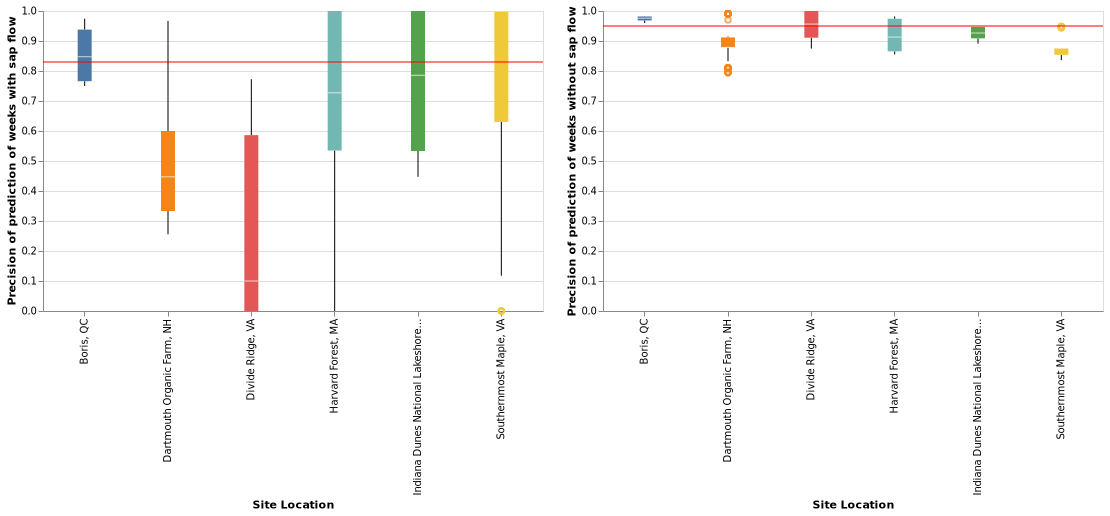

In [45]:
# Generate plots showing prediction precision by site (red lines for comparison to precision reported by Houle et al., 2015

prec_1_plt = (
    alt.Chart(houle_summary)
    .mark_boxplot()
    .encode(
        y=alt.Y("precision_1", title="Precision of prediction of weeks with sap flow"),
        x=alt.X("loc", title="Site Location"),
        color = alt.Color("loc", legend=None)
    )
)
prec_0_plt = (
    alt.Chart(houle_summary)
    .mark_boxplot()
    .encode(
        y=alt.Y(
            "precision_0", title="Precision of prediction of weeks without sap flow"
        ),
        x=alt.X("loc", title="Site Location"),
        color = alt.Color("loc", legend=None)
    )
)

houle_means = pd.DataFrame({"prec_1": [0.83], "prec_0": [0.95]})

prec_0_plt = prec_0_plt + alt.Chart(houle_means).mark_rule(color="red").encode(
    y="prec_0"
)
prec_1_plt = prec_1_plt + alt.Chart(houle_means).mark_rule(color="red").encode(
    y="prec_1"
)

width = 500
(prec_1_plt.properties(width=width) | prec_0_plt.properties(width=width))

<ipython-input-65-82f500f94139>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_sigmoid['prediction'] = sample_sigmoid.apply(


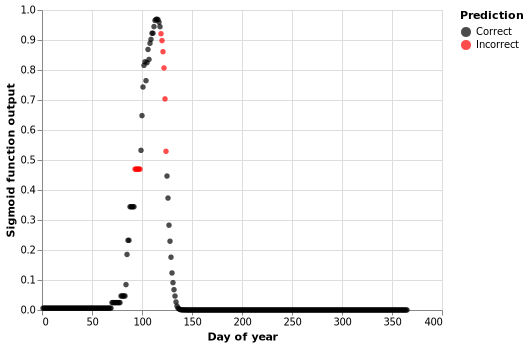

In [65]:
# Creates sample plot demonstrating output of sigmoid function over the course of a year.  Correct predictions in orange, incorrect in blue

sample_sigmoid = houle2015[
    (houle2015.site == "QC")
    & (houle2015.date_to.dt.year == 2015)
    & (houle2015.tap_id == "QC1A")
]
sample_sigmoid['prediction'] = sample_sigmoid.apply(
    lambda x: 'Correct' if (x.correct == 1) else 'Incorrect', axis=1
)

alt.Chart(sample_sigmoid).mark_circle().encode(
    alt.X("jd", title="Day of year"),
    alt.Y("S", title="Sigmoid function output"),
    fill=alt.Fill("prediction", title="Prediction", scale=alt.Scale(
            domain=['Correct', 'Incorrect'],
            range=['black', 'red'])),
)

In [47]:
log_regs = dict()
for site in houle2015.site.unique():
    X = houle2015[houle2015.site==site][["F", "F2", "G"]]
    y = houle2015[houle2015.site==site][['Y']]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state = 123, stratify = houle2015[houle2015.site==site].tap_id)
    log_regs[site] = LogisticRegression()
    log_regs[site].fit(X_train, y_train)
    log_regs[site].score(X_train,y_train)



/home/steffen/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/steffen/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/steffen/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/steffen/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

In [59]:
for site in houle2015.site.unique():
    houle2015.loc[houle2015.site==site,'Y_logreg'] = log_regs[site].predict(houle2015.loc[houle2015.site==site, ["F", "F2", "G"]])

In [60]:
houle2015.loc[:, "log_reg_correct"] = (houle2015.Y_hat == houle2015.Y_logreg).astype(
    "int"
)  # Add column indicating if prediction was correct or not

# Add columns to count number of true positives, false positives, false negatives, and true negatives
houle2015["tp_lr"] = houle2015.apply(
    lambda x: 1 if (x.Y == 1 and x.Y_logreg == 1) else 0, axis=1
)
houle2015["fp_lr"] = houle2015.apply(
    lambda x: 1 if (x.Y == 0 and x.Y_logreg == 1) else 0, axis=1
)
houle2015["fn_lr"] = houle2015.apply(
    lambda x: 1 if (x.Y == 1 and x.Y_logreg == 0) else 0, axis=1
)
houle2015["tn_lr"] = houle2015.apply(
    lambda x: 1 if (x.Y == 0 and x.Y_logreg == 0) else 0, axis=1
)

In [80]:
# Calculate summary of performance of Houle et al., 2015 model in terms of precision of prediction for weeks with sap flow (`precision_1`) 
# and prediction of weeks without sap flow (`precision_0`).
houle_summary.loc[:,["tn_lr", "fp_lr", "fn_lr", "tp_lr"]] = (
    houle2015[["site", "tap_id", "year", "tn_lr", "fp_lr", "fn_lr", "tp_lr"]]
    .groupby(["tap_id", "year", "site"])
    .sum()
).reset_index()
houle_summary["precision_1_lr"] = houle_summary.tp_lr / (houle_summary.tp_lr + houle_summary.fn_lr)
houle_summary["precision_0_lr"] = houle_summary.tn_lr / (houle_summary.tn_lr + houle_summary.fp_lr)
houle_summary

,tap_id,year,site,tn,fp,fn,tp,precision_1,precision_0,long_name,state_province,loc,tn_lr,fp_lr,fn_lr,tp_lr,precision_1_lr,precision_0_lr
0,DOF10A,2014,DOF,265,62,21,17,0.447368,0.810398,Dartmouth Organic Farm,NH,"Dartmouth Organic Farm, NH",321,6,5,33,0.868421,0.981651
1,DOF10A,2015,DOF,322,3,4,36,0.900000,0.990769,Dartmouth Organic Farm,NH,"Dartmouth Organic Farm, NH",325,0,28,12,0.300000,1.000000
2,DOF10A,2016,DOF,290,28,32,16,0.333333,0.911950,Dartmouth Organic Farm,NH,"Dartmouth Organic Farm, NH",317,1,11,37,0.770833,0.996855
3,DOF10A,2017,DOF,290,40,14,21,0.600000,0.878788,Dartmouth Organic Farm,NH,"Dartmouth Organic Farm, NH",314,16,0,35,1.000000,0.951515
4,DOF10B,2014,DOF,265,68,21,11,0.343750,0.795796,Dartmouth Organic Farm,NH,"Dartmouth Organic Farm, NH",326,7,0,32,1.000000,0.978979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
547,SMAS6A,2016,SMM,305,43,0,18,1.000000,0.876437,Southernmost Maple,VA,"Southernmost Maple, VA",340,8,0,18,1.000000,0.977011
548,SMAS7A,2016,SMM,305,44,0,17,1.000000,0.873926,Southernmost Maple,VA,"Southernmost Maple, VA",340,9,0,17,1.000000,0.974212
549,SMAS7B,2016,SMM,305,44,0,17,1.000000,0.873926,Southernmost Maple,VA,"Southernmost Maple, VA",340,9,0,17,1.000000,0.974212
550,SMAS8A,2016,SMM,305,43,0,18,1.000000,0.876437,Southernmost Maple,VA,"Southernmost Maple, VA",340,8,0,18,1.000000,0.977011


<ipython-input-73-96e64de362bc>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_sigmoid['prediction'] = sample_sigmoid.apply(


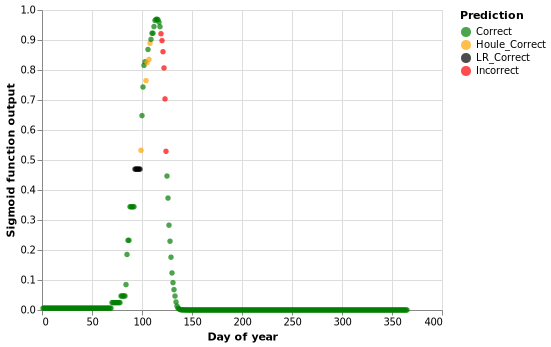

In [73]:
# Creates sample plot demonstrating output of sigmoid function over the course of a year.  Correct predictions in orange, incorrect in blue

sample_sigmoid = houle2015[
    (houle2015.site == "QC")
    & (houle2015.date_to.dt.year == 2015)
    & (houle2015.tap_id == "QC1A")
]
sample_sigmoid['prediction'] = sample_sigmoid.apply(
    lambda x: 'Correct' if (x.correct == 1 and x.log_reg_correct==1) else ('LR_Correct' if (x.correct == 0 and x.log_reg_correct==1) else ('Houle_Correct' if (x.correct == 1 and x.log_reg_correct==0) else 'Incorrect')), axis=1
)

alt.Chart(sample_sigmoid).mark_circle().encode(
    alt.X("jd", title="Day of year"),
    alt.Y("S", title="Sigmoid function output"),
    fill=alt.Fill("prediction", title="Prediction", scale=alt.Scale(
            domain=['Correct','Houle_Correct', 'LR_Correct', 'Incorrect'],
            range=['green', 'orange', 'black', 'red'])),
)

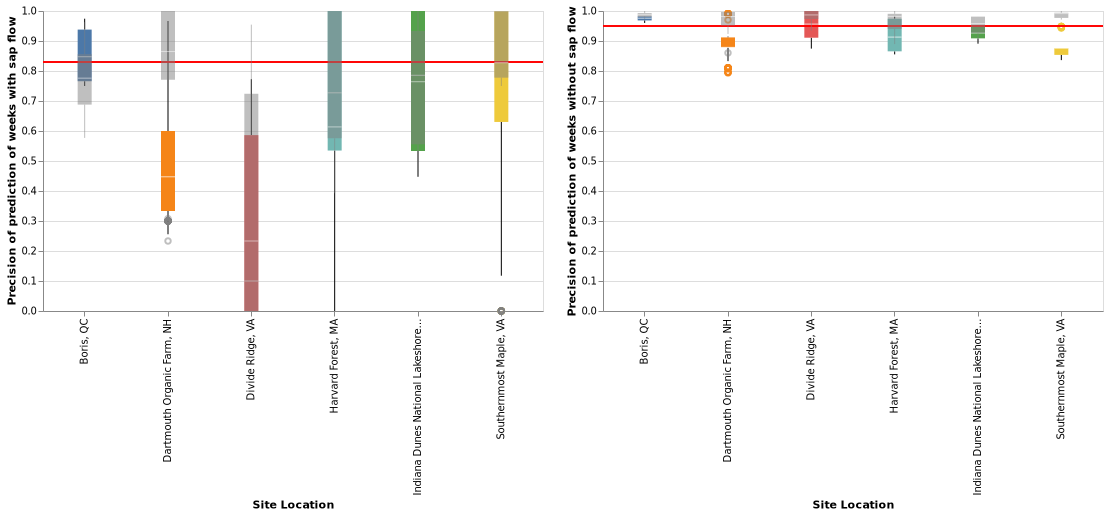

In [86]:
# Generate plots showing prediction precision by site (red lines for comparison to precision reported by Houle et al., 2015

prec_1_plt_lr = (
    alt.Chart(houle_summary)
    .mark_boxplot(color='grey', opacity=0.5)
    .encode(
        y=alt.Y("precision_1_lr", title="Precision of prediction of weeks with sap flow"),
        x=alt.X("loc", title="Site Location"),
#         color = alt.Color("loc", legend=None)
    )
)
prec_0_plt_lr = (
    alt.Chart(houle_summary)
    .mark_boxplot(color='grey', opacity=0.5)
    .encode(
        y=alt.Y(
            "precision_0_lr", title="Precision of prediction of weeks without sap flow"
        ),
        x=alt.X("loc", title="Site Location"),
#         color = alt.Color("loc", legend=None)
    )
)

houle_means = pd.DataFrame({"prec_1": [0.83], "prec_0": [0.95]})

prec_0_plt = prec_0_plt + alt.Chart(houle_means).mark_rule(color="red").encode(
    y="prec_0"
)
prec_1_plt = prec_1_plt + alt.Chart(houle_means).mark_rule(color="red").encode(
    y="prec_1"
)

width = 500
(prec_1_plt.properties(width=width)+prec_1_plt_lr.properties(width=width) | prec_0_plt.properties(width=width) + prec_0_plt_lr.properties(width=width))

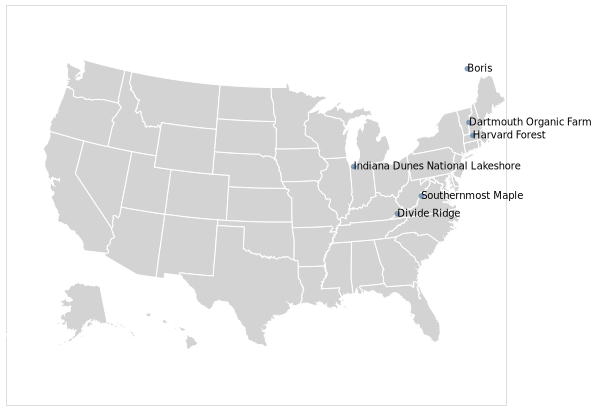

In [109]:
points = alt.Chart(location).mark_circle().encode(
    longitude='lon:Q',
    latitude='lat:Q',
    size=alt.value(30)
)

labels = points.mark_text(
    align='left',
    baseline='middle',
).encode(
    text='long_name',
    size= alt.value(10)
)


states = alt.topo_feature(data.us_10m.url, feature='states')
background = alt.Chart(states).mark_geoshape(
    fill='lightgray',
    stroke='white'
).project('albersUsa').properties(
    width=500,
    height=400
)

background + points + labels